# [book](https://nbviewer.org/github/fastai/fastbook/blob/master/11_midlevel_data.ipynb)

# [Doc](https://docs.fast.ai/tutorial.pets.html)

# Quizz

- Why should we specify types prototype in `Transform.encode()`?
> So that we can have multiple encodes for multiple types!
> It makes the dispatch dynamic

- Why does a `Transform` have a `decode` method?
> usually to be undo the transform so that it's human readable
> but it's more a undo than a repr, for ex, the last transform doesn't give u a human readable format, it gives u the result of the previous transform!

- Why `Transform` have a `setup` method?
> setup some state for the Transform, for example Numericalize().setup(tokens) creates the vocab

- How does a `Transform` work when called on a tuple?
> It applies to each item. The tuple format is usually (input, target). But it's not limited to 2 items

- Which methods do you need to implement when writting your own `Transform`? 
> setup, encode, decode

- What is a pipeline
> help combine transforms, in a certain sequence

- What is `TfmdLists`
> The blueprint version of Pipeline
> It lazily calls the transforms
> So we pass the files and the blueprint of the transforms we want

- What is `Datasets`, how is it different from `TfmdLists`

- Why are `TfmdLists` and Datasets` named with an "s"?
> Because they are tuples that have both training and validation set

- How can you build a `DataLoaders` from a `TfmdLists` or a `Datasets`?

- How do you pass `item_tfms` and `batch_tfms` when building a `DataLoaders` from a `TfmdLists` or a `Datasets`?

- What do you need to do when you want to have your custom items work with methods like `show_batch` and `show_results`?

- Why can we easily apply fastai data augmentation transforms to the `SiamesePair` we built?

- Use the mid-level API to prepare the data in DataLoaders on your own datasets. Try this with the Pet dataset and the Adult dataset from Chapter 1.

- Look at the Siamese tutorial in the fastai documentation to learn how to customize the behavior of `show_batch` and `show_result` for new type of items. Implement it in your own project.

In [4]:
from fastai.imports import *
from fastai.data.all import *
from fastai.vision.all import *
from fastai.text.all import *

# Overview

In this tutorial, we look in depth at the middle level API for collecting data in computer vision. First we will see how to use:
- `Transform` to process data
- `Pipeline` to compose transforms

Those are just functions with added functionality. For dataset processing, we will look in a second part at
- `TfmdLists` to apply one `Pipeline` of `Tranforms` on a collection of items
- `Datasets` to apply several `Pipeline` of `Transforms` on a collection of items in parallel and produce tuples

The general rule is to use `TfmdLists` when your transforms will output the tuple (input,target) and `Datasets` when you build separate Pipelines for each of your input(s)/target(s).

After this tutorial, you might be interested by the [siamese tutorial](https://docs.fast.ai/tutorial.siamese.html) that goes even more in depth in the data APIs, showing you how to write your custom types and how to customize the behavior of `show_batch` and `show_results`.


# Walkthrough The Mid Level API - a Datablock From Scratch

Cleaning and processing data is one of the most time-consuming things in machine learning, which is why fastai tries to help you as much as it can. At its core, preparing the data for your model can be formalized as a sequence of transformations you apply to some raw items.

For instance, in a classic image classification problem:
1. we start with filenames.
2. We have to open the corresponding images,
3. resize them,
4. convert them to tensors,
5. maybe apply some kind of data augmentation, before we are ready to batch them. 


For the targets:
1. we need to extract the label of our filename
2. and convert it to an integer.

This process needs to be somewhat reversible, because we often want to inspect our data to double check what we feed the model actually makes sense. That’s why fastai represents all those operations by `Transforms`, which you can sometimes undo with a `decode` method.

### From Filename To Transform

In [292]:
import pandas as pd

results_df = pd.DataFrame(columns=[''])

def track_results(experiment_name, result, reset=False):
    global results_df
    if reset:
        results_df = pd.DataFrame(columns=[''])
    if hasattr(result, '__dict__') and '__str__' in result.__dict__:
        results_df.loc[experiment_name] = result
    else:
        results_df.loc[experiment_name] = repr(result)
    return results_df

In [308]:
path = untar_data(URLs.IMDB)
files = get_text_files(path, folders = ['train', 'test'])
txts = L(o.open().read() for o in files[:2000])
track_results('original text', txts, reset=True)

original text  ["Alan Rickman & Emma Thompson give good performances with southern/New Orleans accents in this detective flick. It's worth seeing for their scenes- and Rickman's scene with Hal Holbrook. These three actors mannage to entertain us no matter what the movie, it seems. The plot for the movie shows potential, but one gets the impression in watching the film that it was not pulled off as well as it could have been. The fact that it is cluttered by a rather uninteresting subplot and mostly uninteresting kidnappers really muddles things. The movie is worth a view- if for nothing more than enterta...

__encode/decode example with Tokenizer__

In [309]:
tok = Tokenizer.from_folder(path)
tok.setup(txts)

# call tok() is the same as calling tok.encode()
toks = txts.map(tok)
track_results('tokenizer.encode', toks)

original text     ["Alan Rickman & Emma Thompson give good performances with southern/New Orleans accents in this detective flick. It's worth seeing for their scenes- and Rickman's scene with Hal Holbrook. These three actors mannage to entertain us no matter what the movie, it seems. The plot for the movie shows potential, but one gets the impression in watching the film that it was not pulled off as well as it could have been. The fact that it is cluttered by a rather uninteresting subplot and mostly uninteresting kidnappers really muddles things. The movie is worth a view- if for nothing more than enterta...
tokenizer.encode  [['xxbos', 'xxmaj', 'alan', 'xxmaj', 'rickman', '&', 'xxmaj', 'emma', 'xxmaj', 'thompson', 'give', 'good', 'performances', 'with', 'southern', '/', 'xxmaj', 'new', 'xxmaj', 'orleans', 'accents', 'in', 'this', 'detective', 'flick', '.', 'xxmaj', 'it', "'s", 'worth', 'seeing', 'for', 'their', 'scenes-', 'and', 'xxmaj', 'rickman', "'s", 'scene', 'with', 'xxmaj', 'hal', 'xxmaj', 'holbrook', '.', 'xxmaj', 'these', 'three', 'actors', 'mannage', 'to', 'entertain', 'us', 'no', 'matter', 'what', 'the', 'movie', ',', 'it', 'seems', '.', 'xxmaj', 'the', 'plot', 'for', 'the', 'movie', 'shows', 'potent...

In [310]:
# decode is used for human representation and is used by show_batch and show_results() later on
txts.map(tok.decode)
# Tokenizer.decode turns this back into a single string
# (it may not, however, be exactly the same as the original string;
# this depends on whether the tokenizer is reversible, usually it's not reversible as we can see it adds extra space
# the behavior depends on the tokenizer used

(#2000) ["A l a n   R i c k m a n   &   E m m a   T h o m p s o n   g i v e   g o o d   p e r f o r m a n c e s   w i t h   s o u t h e r n / N e w   O r l e a n s   a c c e n t s   i n   t h i s   d e t e c t i v e   f l i c k .   I t ' s   w o r t h   s e e i n g   f o r   t h e i r   s c e n e s -   a n d   R i c k m a n ' s   s c e n e   w i t h   H a l   H o l b r o o k .   T h e s e   t h r e e   a c t o r s   m a n n a g e   t o   e n t e r t a i n   u s   n o   m a t t e r   w h a t   t h e   m o v i e ,   i t   s e e m s .   T h e   p l o t   f o r   t h e   m o v i e   s h o w s   p o t e n t i a l ,   b u t   o n e   g e t s   t h e   i m p r e s s i o n   i n   w a t c h i n g   t h e   f i l m   t h a t   i t   w a s   n o t   p u l l e d   o f f   a s   w e l l   a s   i t   c o u l d   h a v e   b e e n .   T h e   f a c t   t h a t   i t   i s   c l u t t e r e d   b y   a   r a t h e r   u n i n t e r e s t i n g   s u b p l o t   a n d   m o s t l y   u n i n t e r e 

In [311]:
track_results('tokenizer.decode', txts.map(tok.decode))

original text     ["Alan Rickman & Emma Thompson give good performances with southern/New Orleans accents in this detective flick. It's worth seeing for their scenes- and Rickman's scene with Hal Holbrook. These three actors mannage to entertain us no matter what the movie, it seems. The plot for the movie shows potential, but one gets the impression in watching the film that it was not pulled off as well as it could have been. The fact that it is cluttered by a rather uninteresting subplot and mostly uninteresting kidnappers really muddles things. The movie is worth a view- if for nothing more than enterta...
tokenizer.encode  [['xxbos', 'xxmaj', 'alan', 'xxmaj', 'rickman', '&', 'xxmaj', 'emma', 'xxmaj', 'thompson', 'give', 'good', 'performances', 'with', 'southern', '/', 'xxmaj', 'new', 'xxmaj', 'orleans', 'accents', 'in', 'this', 'detective', 'flick', '.', 'xxmaj', 'it', "'s", 'worth', 'seeing', 'for', 'their', 'scenes-', 'and', 'xxmaj', 'rickman', "'s", 'scene', 'with', 'xxmaj', 'hal', 'xxmaj', 'holbrook', '.', 'xxmaj', 'these', 'three', 'actors', 'mannage', 'to', 'entertain', 'us', 'no', 'matter', 'what', 'the', 'movie', ',', 'it', 'seems', '.', 'xxmaj', 'the', 'plot', 'for', 'the', 'movie', 'shows', 'potent...
tokenizer.decode  ["A l a n   R i c k m a n   &   E m m a   T h o m p s o n   g i v e   g o o d   p e r f o r m a n c e s   w i t h   s o u t h e r n / N e w   O r l e a n s   a c c e n t s   i n   t h i s   d e t e c t i v e   f l i c k .   I t ' s   w o r t h   s e e i n g   f o r   t h e i r   s c e n e s -   a n d   R i c k m a n ' s   s c e n e   w i t h   H a l   H o l b r o o k .   T h e s e   t h r e e   a c t o r s   m a n n a g e   t o   e n t e r t a i n   u s   n o   m a t t e r   w h a t   t h e   m o v i e ,   i t   s e e m s .   T h e   p l o t   f o r   t h e   m o v i e   s h o w s   p o t ...

__encode/decode example with Numericalize__

In [312]:
track_results('original', toks, reset=True)

original  [['xxbos', 'xxmaj', 'alan', 'xxmaj', 'rickman', '&', 'xxmaj', 'emma', 'xxmaj', 'thompson', 'give', 'good', 'performances', 'with', 'southern', '/', 'xxmaj', 'new', 'xxmaj', 'orleans', 'accents', 'in', 'this', 'detective', 'flick', '.', 'xxmaj', 'it', "'s", 'worth', 'seeing', 'for', 'their', 'scenes-', 'and', 'xxmaj', 'rickman', "'s", 'scene', 'with', 'xxmaj', 'hal', 'xxmaj', 'holbrook', '.', 'xxmaj', 'these', 'three', 'actors', 'mannage', 'to', 'entertain', 'us', 'no', 'matter', 'what', 'the', 'movie', ',', 'it', 'seems', '.', 'xxmaj', 'the', 'plot', 'for', 'the', 'movie', 'shows', 'potent...

In [313]:
num = Numericalize()
num.setup(toks)
nums = toks.map(num)

track_results('numericalize.encode', nums[0][:10])

original             [['xxbos', 'xxmaj', 'alan', 'xxmaj', 'rickman', '&', 'xxmaj', 'emma', 'xxmaj', 'thompson', 'give', 'good', 'performances', 'with', 'southern', '/', 'xxmaj', 'new', 'xxmaj', 'orleans', 'accents', 'in', 'this', 'detective', 'flick', '.', 'xxmaj', 'it', "'s", 'worth', 'seeing', 'for', 'their', 'scenes-', 'and', 'xxmaj', 'rickman', "'s", 'scene', 'with', 'xxmaj', 'hal', 'xxmaj', 'holbrook', '.', 'xxmaj', 'these', 'three', 'actors', 'mannage', 'to', 'entertain', 'us', 'no', 'matter', 'what', 'the', 'movie', ',', 'it', 'seems', '.', 'xxmaj', 'the', 'plot', 'for', 'the', 'movie', 'shows', 'potent...
numericalize.encode                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 TensorText([   2,    8, 2979,    8, 7868,  195,    8, 6641,    8, 5032])

In [314]:
# decode doesn't return a string, but instead, undo the transform
decoded = num.decode(nums[0][:10])
track_results('numericalize.decode', decoded)


original             [['xxbos', 'xxmaj', 'alan', 'xxmaj', 'rickman', '&', 'xxmaj', 'emma', 'xxmaj', 'thompson', 'give', 'good', 'performances', 'with', 'southern', '/', 'xxmaj', 'new', 'xxmaj', 'orleans', 'accents', 'in', 'this', 'detective', 'flick', '.', 'xxmaj', 'it', "'s", 'worth', 'seeing', 'for', 'their', 'scenes-', 'and', 'xxmaj', 'rickman', "'s", 'scene', 'with', 'xxmaj', 'hal', 'xxmaj', 'holbrook', '.', 'xxmaj', 'these', 'three', 'actors', 'mannage', 'to', 'entertain', 'us', 'no', 'matter', 'what', 'the', 'movie', ',', 'it', 'seems', '.', 'xxmaj', 'the', 'plot', 'for', 'the', 'movie', 'shows', 'potent...
numericalize.encode                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 TensorText([   2,    8, 2979,    8, 7868,  195,    8, 6641,    8, 5032])
numericalize.decode                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ['xxbos', 'xxmaj', 'alan', 'xxmaj', 'rickman', '&', 'xxmaj', 'emma', 'xxmaj', 'thompson']

__why do we need setup()__

 initialize some inner state (like the vocab inside num)

In [323]:
num = Numericalize()
num.setup(toks)
num.vocab

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 'the',
 '.',
 ',',
 'a',
 'and',
 'of',
 'to',
 'is',
 'it',
 'i',
 'in',
 'this',
 'that',
 '"',
 "'s",
 'was',
 '-',
 '\n\n',
 'movie',
 'for',
 'with',
 'but',
 "n't",
 'as',
 'film',
 'on',
 'you',
 'not',
 'have',
 ')',
 '(',
 'are',
 'be',
 'he',
 'they',
 'one',
 'all',
 'his',
 'at',
 'like',
 'so',
 'there',
 'just',
 '?',
 'do',
 'an',
 '!',
 'if',
 'or',
 'by',
 'from',
 'who',
 'out',
 'about',
 'some',
 'what',
 'no',
 "'",
 'has',
 'would',
 'her',
 'even',
 'bad',
 'up',
 '…',
 'good',
 'when',
 'only',
 'more',
 'did',
 'time',
 'my',
 'really',
 'were',
 'had',
 'she',
 'can',
 'very',
 'could',
 'me',
 'which',
 'their',
 'does',
 'been',
 'get',
 'much',
 'we',
 'than',
 'story',
 'see',
 'how',
 ':',
 'into',
 'people',
 'make',
 'movies',
 'because',
 'other',
 'made',
 'any',
 'then',
 'well',
 'too',
 'most',
 'them',
 'plot',
 'him',
 'first',
 'also',
 'way',
 'off',
 'ac

__Transform applies to a tuple__

In [331]:
# it applies to both part of the tuple, usually the tuple is (input, target)
tok((txts[0], txts[1]))

((#139) ['xxbos','xxmaj','alan','xxmaj','rickman','&','xxmaj','emma','xxmaj','thompson'...],
 (#152) ['xxbos','i','have','seen','this','movie','and','i','did','not'...])

In [332]:
# it's more rare but it can also apply to a list
tok((txts[0], txts[1], txts[2], txts[3]))

((#139) ['xxbos','xxmaj','alan','xxmaj','rickman','&','xxmaj','emma','xxmaj','thompson'...],
 (#152) ['xxbos','i','have','seen','this','movie','and','i','did','not'...],
 (#226) ['xxbos','xxmaj','in','xxmaj','los','xxmaj','angeles',',','the','alcoholic'...],
 (#605) ['xxbos','xxmaj','this','film','is','bundled','along','with','"','gli'...])

### Pipeline Let You Chain Transforms

Basically it's a stack that call encode in chain

In [324]:
pipeline = Pipeline([tok, num])
t = pipeline(txts[0])
track_results('original', str(txts[0]), reset=True)
track_results('pipeline.encode', str(t))

original         "Alan Rickman & Emma Thompson give good performances with southern/New Orleans accents in this detective flick. It's worth seeing for their scenes- and Rickman's scene with Hal Holbrook. These three actors mannage to entertain us no matter what the movie, it seems. The plot for the movie shows potential, but one gets the impression in watching the film that it was not pulled off as well as it could have been. The fact that it is cluttered by a rather uninteresting subplot and mostly uninteresting kidnappers really muddles things. The movie is worth a view- if for nothing more than entertai...
pipeline.encode  'TensorText([   2,    8, 2979,    8, 7868,  195,    8, 6641,    8, 5032,  210,\n              74,  706,   29, 3203,  122,    8,  243,    8, 5744, 2001,   19,\n              20, 1686,  412,   10,    8,   17,   23,  336,  325,   28,   90,\n               0,   13,    8, 7868,   23,  153,   29,    8, 5745,    8,    0,\n              10,    8,  148,  324,  165,    0,   15, 3442,  274,   65,  466,\n              64,    9,   27,   11,   17,  192,   10,    8,    9,  114,   28,\n               9,   27,  381,  925,   11,   30,   44,  225,    9, 1406,   19,\n             156,    9,   33,   21,   17, ...

In [325]:
decoded = pipeline.decode(t)[:100]
track_results('pipeline.decode', decoded)
# decode doesn't give the original text!
# it works like an undo!
# it gives the input before the last transform

original         "Alan Rickman & Emma Thompson give good performances with southern/New Orleans accents in this detective flick. It's worth seeing for their scenes- and Rickman's scene with Hal Holbrook. These three actors mannage to entertain us no matter what the movie, it seems. The plot for the movie shows potential, but one gets the impression in watching the film that it was not pulled off as well as it could have been. The fact that it is cluttered by a rather uninteresting subplot and mostly uninteresting kidnappers really muddles things. The movie is worth a view- if for nothing more than entertai...
pipeline.encode  'TensorText([   2,    8, 2979,    8, 7868,  195,    8, 6641,    8, 5032,  210,\n              74,  706,   29, 3203,  122,    8,  243,    8, 5744, 2001,   19,\n              20, 1686,  412,   10,    8,   17,   23,  336,  325,   28,   90,\n               0,   13,    8, 7868,   23,  153,   29,    8, 5745,    8,    0,\n              10,    8,  148,  324,  165,    0,   15, 3442,  274,   65,  466,\n              64,    9,   27,   11,   17,  192,   10,    8,    9,  114,   28,\n               9,   27,  381,  925,   11,   30,   44,  225,    9, 1406,   19,\n             156,    9,   33,   21,   17, ...
pipeline.decode                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   'xxbos xxmaj alan xxmaj rickman & xxmaj emma xxmaj thompson give good performances with southern / xx'

### TfmdLists As Pipeline Blueprint

In [349]:
# we can do everything we did with pipeline
# but more simply
# we just specify:
# - files
# - transforms to apply (without calling them)
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize])
t = tls[0]; t[:20]

TensorText([   2,    8, 1858,    8, 9699,  203,    8, 3682,    8, 4445,  221,
              68,  378,   28, 2439,  125,    8,  186,    8, 5648])

In [350]:
tls.decode(t)[:100]

'xxbos xxmaj alan xxmaj rickman & xxmaj emma xxmaj thompson give good performances with southern / xx'

In [351]:
# same as pipeline it also has a show()
tls.show(t)

xxbos xxmaj alan xxmaj rickman & xxmaj emma xxmaj thompson give good performances with southern / xxmaj new xxmaj orleans accents in this detective flick . xxmaj it 's worth seeing for their scenes- and xxmaj rickman 's scene with xxmaj hal xxmaj holbrook . xxmaj these three actors xxunk to entertain us no matter what the movie , it seems . xxmaj the plot for the movie shows potential , but one gets the impression in watching the film that it was not pulled off as well as it could have been . xxmaj the fact that it is cluttered by a rather uninteresting subplot and mostly uninteresting kidnappers really muddles things . xxmaj the movie is worth a xxunk if for nothing more than entertaining performances by xxmaj rickman , xxmaj thompson , and xxmaj holbrook .


__TfmdLists is called with an s, because it handles both training and validation set__

In [355]:
cut = int(len(files)*0.8)
splits = [list(range(cut)), list(range(cut,len(files)))]
transformed_list = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize], 
                splits=splits)

In [356]:
# first 20 tokens of first row
transformed_list.valid[0][:20]

TensorText([    2,     8,  1713,   751,   175,   625,    11,    19,  1217,
               20,    32,    18,    66,   439,    23,  4596,    18,     8,
            56285,    12])

In [357]:
transformed_list.decode(tls.valid[0][:20])

"xxbos xxmaj twenty five years ago , i showed this film in some children 's classes in xxmaj entomology and"

### Datasets contains 1 TfmdLists for inputs + 1 TfmdLists for labels

__recap:__
- TfmdLists have 2 branches, training and validation set
- Datasets have (usually) 2 branches, one TfmdList for inputs, and another for labels

In [363]:
# first get labels using the parent_label func (or might depends on how your dataset is setup)
lbls = files.map(parent_label)
lbls

(#50000) ['neg','neg','neg','neg','neg','neg','neg','neg','neg','neg'...]

In [362]:
# Then we need to transform these strings to tensors
cat = Categorize()
cat.setup(lbls)
cat.vocab, cat(lbls[0])

(['neg', 'pos'], TensorCategory(0))

In [364]:
# and that's how you do the whole thing using TfmdLists
tls_y = TfmdLists(files, [parent_label, Categorize()])
tls_y[0]

TensorCategory(0)

__now is time to group these TfmdLists together so that we can iterate in the same order__

- Datasets will run both pipelines (TfmdLists) in parallel
- TfmdLists will automatically do the setup for us
- We can then use Datasets to properly iterate through the dataset one row at a time
- In conclusion datasets, restitch everything together properly for us so that we just iterate row by row without having to worry about which pipeline to use

In [367]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]

dsets = Datasets(files, [x_tfms, y_tfms])
x,y = dsets[0]
x[:20],y

(TensorText([   2,    8, 1858,    8, 9699,  203,    8, 3682,    8, 4445,  221,
               68,  378,   28, 2439,  125,    8,  186,    8, 5648]),
 TensorCategory(0))

In [368]:
# don't forget to pass the splits!
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms], splits=splits)
x,y = dsets.valid[0]
x[:20],y

(TensorText([    2,     8,  1713,   751,   175,   625,    11,    19,  1217,
                20,    32,    18,    66,   439,    23,  4596,    18,     8,
             56285,    12]),
 TensorCategory(1))

In [371]:
# as expected tt can decode any processed tuple or show it directly:
t = dsets.valid[0]
dsets.decode(t)

("xxbos xxmaj alan xxmaj rickman & xxmaj emma xxmaj thompson give good performances with southern / xxmaj new xxmaj orleans accents in this detective flick . xxmaj it 's worth seeing for their scenes- and xxmaj rickman 's scene with xxmaj hal xxmaj holbrook . xxmaj these three actors xxunk to entertain us no matter what the movie , it seems . xxmaj the plot for the movie shows potential , but one gets the impression in watching the film that it was not pulled off as well as it could have been . xxmaj the fact that it is cluttered by a rather uninteresting subplot and mostly uninteresting kidnappers really muddles things . xxmaj the movie is worth a xxunk if for nothing more than entertaining performances by xxmaj rickman , xxmaj thompson , and xxmaj holbrook .",
 'neg')

__dataloader__

The last step is to convert our Datasets object to a DataLoaders, which can be done with the dataloaders method. Here we need to pass along a special argument to take care of the padding problem (as we saw in the last chapter). This needs to happen just before we batch the elements, so we pass it to before_batch

In [372]:
dls = dsets.dataloaders(bs=64, before_batch=pad_input)

`dataloaders` directly calls `DataLoader` on each subset of our `Datasets`. fastai's `DataLoader` expands the PyTorch class of the same name and is responsible for collating the items from our datasets into batches. It has a lot of points of customization, but the most important ones that you should know are:

- `after_item`:: Applied on each item after grabbing it inside the dataset. This is the equivalent of `item_tfms` in `DataBlock`.
- `before_batch`:: Applied on the list of items before they are collated. This is the ideal place to pad items to the same size.
- `after_batch`:: Applied on the batch as a whole after its construction. This is the equivalent of `batch_tfms` in `DataBlock`

In [370]:
# In conclusion this...
# path = untar_data(URLs.IMDB)
# dls = DataBlock(
#     blocks=(TextBlock.from_folder(path),CategoryBlock),
#     get_y = parent_label,
#     get_items=partial(get_text_files, folders=['train', 'test']),
#     splitter=GrandparentSplitter(valid_name='test')
# ).dataloaders(path)

# == this code
tfms = [[Tokenizer.from_folder(path), Numericalize], [parent_label, Categorize]]
files = get_text_files(path, folders = ['train', 'test'])
splits = GrandparentSplitter(valid_name='test')(files)
dsets = Datasets(files, tfms, splits=splits)
dls = dsets.dataloaders(dl_type=SortedDL, before_batch=pad_input)

The two differences from the previous code are the use of GrandparentSplitter to split our training and validation data, and the dl_type argument. This is to tell dataloaders to use the SortedDL class of DataLoader, and not the usual one. SortedDL constructs batches by putting samples of roughly the same lengths into batches.

# Example With Pets dataset

### Implementing Decode For Showing Process Data in show_batch()

In [374]:
source = untar_data(URLs.PETS)/"images"
items = get_image_files(source)

In [375]:
# We’ll use this function to create consistently sized tensors from image files:
def resized_image(fn:Path, sz=128):
    x = Image.open(fn).convert('RGB').resize((sz,sz))
    # Convert image to tensor for modeling
    return tensor(array(x)).permute(2,0,1).float()/255.

In [376]:
# Before we can create a Transform, 
# we need a type that knows how to show itself 
# (if we want to use the show method). Here we define a TitledImage
class TitledImage(fastuple):
    def show(self, ctx=None, **kwargs): show_titled_image(self, ctx=ctx, **kwargs)

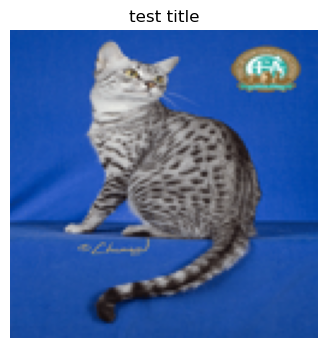

In [377]:
img = resized_image(items[0])
TitledImage(img,'test title').show()

In [378]:
# For our image to appear with a label as in show_batch()
# we need to implement the transform
class PetTfm(Transform):
    def __init__(self, vocab, o2i, lblr): self.vocab,self.o2i,self.lblr = vocab,o2i,lblr
    def encodes(self, o): return [resized_image(o), self.o2i[self.lblr(o)]]
    def decodes(self, x): return TitledImage(x[0],self.vocab[x[1]])

labeller = using_attr(RegexLabeller(pat = r'^(.*)_\d+.jpg$'), 'name')
vals = list(map(labeller, items))
vocab,o2i = uniqueify(vals, sort=True, bidir=True)
pets = PetTfm(vocab,o2i,labeller)

x,y = pets(items[0])
x.shape,y

(torch.Size([3, 128, 128]), 5)

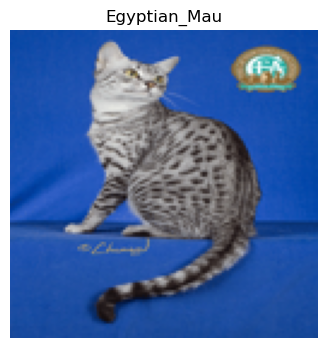

In [379]:
dec = pets.decode([x,y])
dec.show()

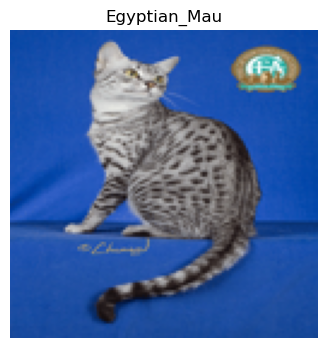

In [380]:
# Note that like __call__ and encodes, we implemented a decodes method
# but we actually call decode on our Transform.

# Also note that our decodes method received the two objects (x and y).
# We said in the previous section Transform dispatch over tuples 
# (for the encoding as well as the decoding)
# but here it took our two elements as a whole
# and did not try to decode x and y separately.
# Why is that? It’s because we pass a list [x,y] to decodes.
# Transforms dispatch over tuples, but tuples only. 
#And as we saw as well, to prevent a Transform from dispatching over a tuple,
# we just have to make it an ItemTransform:
class PetTfm(ItemTransform):
    def __init__(self, vocab, o2i, lblr): self.vocab,self.o2i,self.lblr = vocab,o2i,lblr
    def encodes(self, o): return (resized_image(o), self.o2i[self.lblr(o)])
    def decodes(self, x): return TitledImage(x[0],self.vocab[x[1]])

dec = pets.decode(pets(items[0]))
dec.show()

### Setting up the internal state with a setups

In [381]:
# we are missing the setup phase
class PetTfm(ItemTransform):
    def setups(self, items):
        self.labeller = using_attr(RegexLabeller(pat = r'^(.*)_\d+.jpg$'), 'name')
        vals = map(self.labeller, items)
        self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)

    def encodes(self, o): return (resized_image(o), self.o2i[self.labeller(o)])
    def decodes(self, x): return TitledImage(x[0],self.vocab[x[1]])

In [382]:
pets = PetTfm()
pets.setup(items)
x,y = pets(items[0])
x.shape, y

(torch.Size([3, 128, 128]), 5)

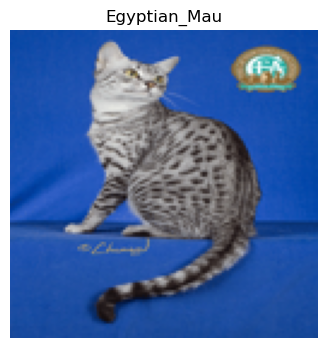

In [383]:
# note the difference from before having the setup!!
# we couldn't do pets.decode([x,y]) WITH BRACKETS before
dec = pets.decode((x,y))
dec.show()

### Combining our Transform with data augmentation in a Pipeline.

In [384]:
class PetTfm(ItemTransform):
    def setups(self, items):
        self.labeller = using_attr(RegexLabeller(pat = r'^(.*)_\d+.jpg$'), 'name')
        vals = map(self.labeller, items)
        self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)

    def encodes(self, o): return (PILImage.create(o), self.o2i[self.labeller(o)])
    def decodes(self, x): return TitledImage(x[0],self.vocab[x[1]])

In [385]:
tfms = Pipeline([PetTfm(), Resize(224), FlipItem(p=1), ToTensor()])

In [386]:
tfms.setup(items)

To check the setup was done properly, we want to see if we did build the vocab. One cool trick of Pipeline is that when asking for an attribute, it will look through each of its Transforms for that attribute and give you the result (or the list of results if the attribute is in multiple transforms):

In [387]:
tfms.vocab

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [388]:
x,y = tfms(items[0])
x.shape,y

(torch.Size([3, 224, 224]), 5)

Pipeline.show will call decode on each Transform until it gets a type that knows how to show itself. The library considers a tuple as knowing how to show itself if all its parts have a show method. Here it does not happen before reaching PetTfm since the second part of our tuple is an int. But after decoding the original PetTfm, we get a TitledImage which has a show method.

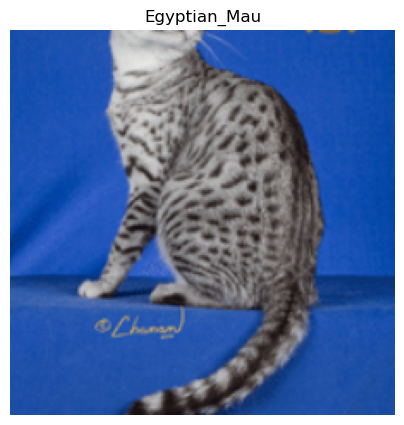

In [389]:
tfms.show(tfms(items[0]))

It’s a good point to note that the Transforms of the Pipeline are sorted by their internal order attribute (with a default of order=0). You can always check the order in which the transforms are in a Pipeline by looking at its representation:

In [390]:
tfms

Pipeline: PetTfm -> FlipItem -- {'p': 1} -> Resize -- {'size': (224, 224), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0} -> ToTensor

Even if we define tfms with Resize before FlipItem, we can see they have been reordered because we have:

In [391]:
FlipItem.order,Resize.order

(0, 1)

To customize the order of a Transform, just set order = ... before the __init__ (it’s a class attribute). Let’s make PetTfm of order -5 to be sure it’s always run first:

In [392]:
class PetTfm(ItemTransform):
    order = -1
    def setups(self, items):
        self.labeller = using_attr(RegexLabeller(pat = r'^(.*)_\d+.jpg$'), 'name')
        vals = map(self.labeller, items)
        self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)

    def encodes(self, o): return (PILImage.create(o), self.o2i[self.labeller(o)])
    def decodes(self, x): return TitledImage(x[0],self.vocab[x[1]])

Then we can mess up the order of the transforms in our Pipeline but it will fix itself:

In [393]:
tfms = Pipeline([Resize(224), PetTfm(), FlipItem(p=1), ToTensor()])
tfms

Pipeline: PetTfm -> FlipItem -- {'p': 1} -> Resize -- {'size': (224, 224), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0} -> ToTensor

### From Pipeline To TfmdLists and Datasets

TfmdList = 
- list of items
- list of tranforms (Pipeline)

In [394]:
tls = TfmdLists(items, [Resize(224), PetTfm(), FlipItem(p=0.5), ToTensor()])
x,y = tls[0]
x.shape,y

(torch.Size([3, 224, 224]), 5)

In [444]:
# setup is called automatically bt TfmdLists
tls.vocab[:10]

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue']

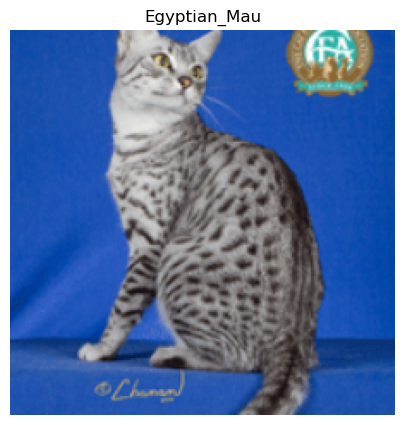

In [399]:
# same as tls.show((x,y))
show_at(tls, 0)

### Training and Validation Sets

In [401]:
splits = RandomSplitter(seed=42)(items)
splits

((#5912) [5643,5317,5806,3460,613,5456,2968,3741,10,4908...],
 (#1478) [4512,4290,5770,706,2200,4320,6450,501,1290,6435...])

In [402]:
tls = TfmdLists(items, [Resize(224), PetTfm(), FlipItem(p=0.5), ToTensor()], splits=splits)

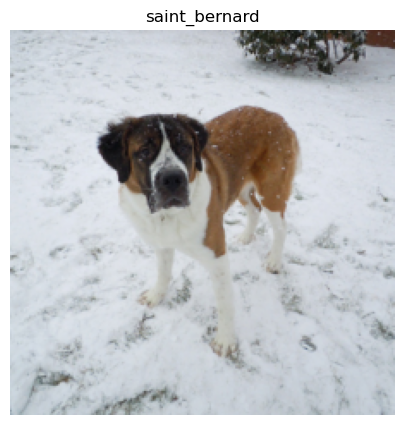

In [403]:
show_at(tls.train, 0)

### From TfmdList To DataLoader

In [404]:
dls = tls.dataloaders(bs=64)

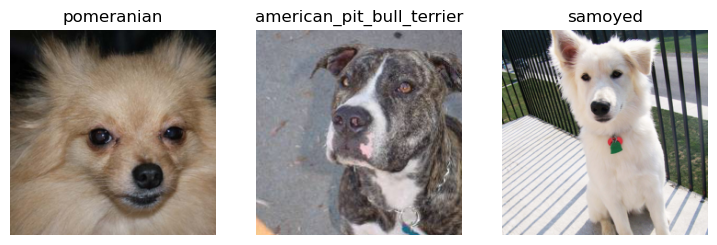

In [406]:
dls.show_batch(max_n=3)

- We can even add augmentation at this point
- just remember to add the IntToFloatTensor transform that deals with the conversion of int to float (aug transforms of fastai on the GPU require float tensors)
- `DataBlock.batch_tfms` corresponds to `DataLoader.after_batch`
- `DataBlock.item_tfms` == `DataLoader.after_item`

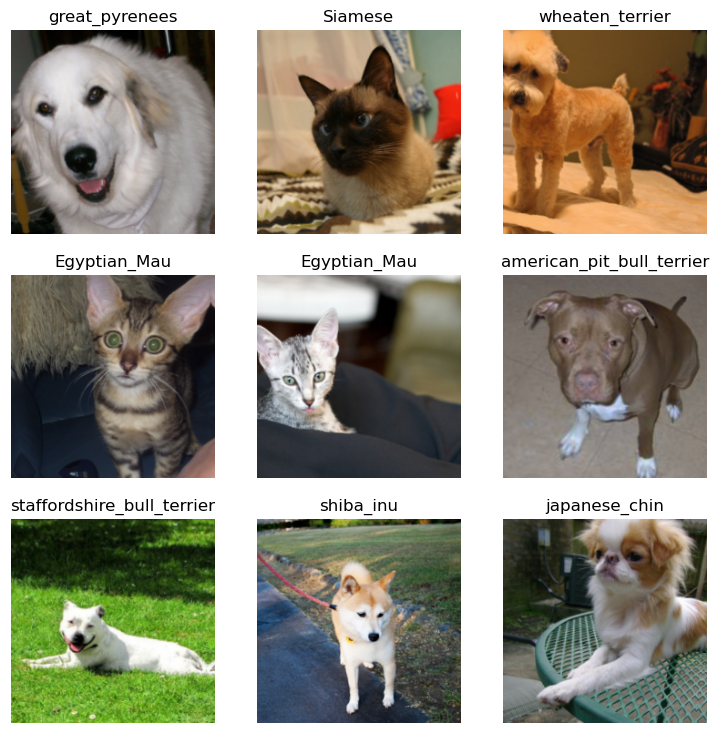

In [411]:
dls = tls.dataloaders(device='cpu',
                      bs=64,
                      after_batch=[IntToFloatTensor(), *aug_transforms()])
dls.show_batch()

### Finally Datasets To Wrap The Whole Thing

The things to note:
- order forces the order in the pipeline

In [480]:
class ImageResizer(Transform):
    order=1
    "Resize image to `size` using `resample`"
    def __init__(self, size, resample=BILINEAR):
        if not is_listy(size): size=(size,size)
        self.size,self.resample = (size[1],size[0]),resample

    def encodes(self, o:PILImage): return o.resize(size=self.size, resample=self.resample)

A datasets it simply:
- the items
- two TfmdLists (pipelines blueprints)

In [449]:
tfms_x = [PILImage.create, ImageResizer(128), ToTensor(), IntToFloatTensor()]
tmds_y = [labeller, Categorize()]

dsets = Datasets(items, [tfms_x, tmds_y])

In [451]:
t = dsets[0]
type(t[0]),type(t[1])

(fastai.torch_core.TensorImage, fastai.torch_core.TensorCategory)

In [415]:
x,y = dsets.decode(t)
x.shape,y

(torch.Size([3, 128, 128]), 'Egyptian_Mau')

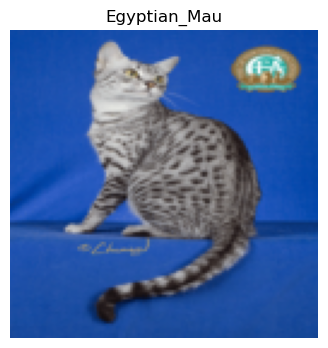

In [416]:
dsets.show(t);

don't forget that we need a validation and training splits!

In [457]:
dsets = Datasets(items, tfms, splits=splits)
dsets.valid[0]

(PILImage mode=RGB size=500x363, TensorCategory(28))

In [464]:
tfms_x = [PILImage.create]
tmfs_y = [labeller, Categorize()]
dsets = Datasets(items, [tfms_x, tmfs_y], splits=splits)
dls = dsets.dataloaders(bs=64, after_item=[ImageResizer(128), ToTensor(), IntToFloatTensor()])

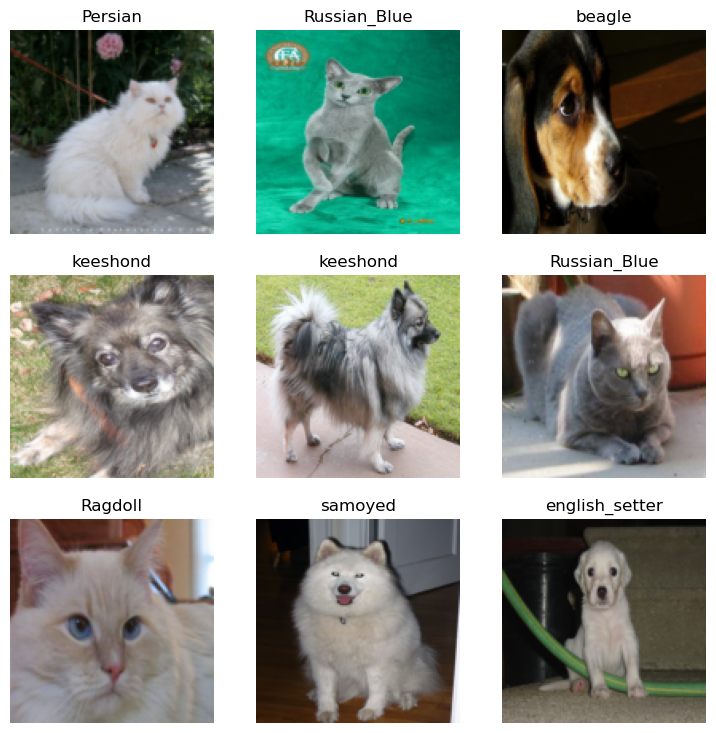

In [465]:
dls.show_batch()

### Finally Finally! Test DataLoader For Inference

In [441]:
tfms = [[PILImage.create], [labeller, Categorize()]]
dsets = Datasets(items, tfms, splits=splits)
dls = dsets.dataloaders(bs=64, after_item=[ImageResizer(128), ToTensor(), IntToFloatTensor()])

In [442]:
# imagine these are new files to predict
path = untar_data(URLs.IMAGENETTE_160)
tst_files = get_image_files(path)
tst_files

(#13394) [Path('/Users/cactus/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00046669.JPEG'),Path('/Users/cactus/.fastai/data/imagenette2-160/train/n03394916/n03394916_58454.JPEG'),Path('/Users/cactus/.fastai/data/imagenette2-160/train/n03394916/n03394916_32588.JPEG'),Path('/Users/cactus/.fastai/data/imagenette2-160/train/n03394916/n03394916_33663.JPEG'),Path('/Users/cactus/.fastai/data/imagenette2-160/train/n03394916/n03394916_27948.JPEG'),Path('/Users/cactus/.fastai/data/imagenette2-160/train/n03394916/n03394916_38644.JPEG'),Path('/Users/cactus/.fastai/data/imagenette2-160/train/n03394916/n03394916_35076.JPEG'),Path('/Users/cactus/.fastai/data/imagenette2-160/train/n03394916/n03394916_38214.JPEG'),Path('/Users/cactus/.fastai/data/imagenette2-160/train/n03394916/n03394916_23008.JPEG'),Path('/Users/cactus/.fastai/data/imagenette2-160/train/n03394916/n03394916_33008.JPEG')...]

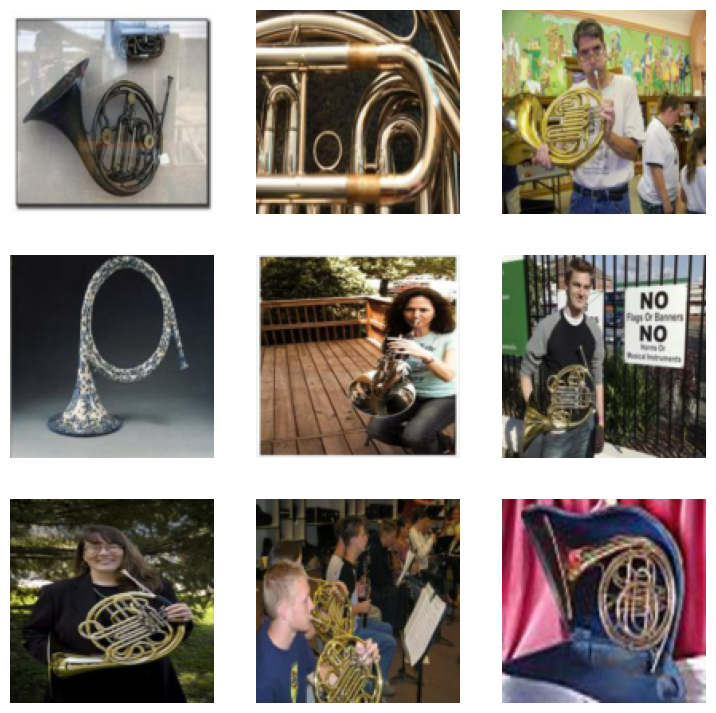

In [443]:
tst_dl = dls.test_dl(tst_files)
tst_dl.show_batch(max_n=9)

- of course it doesn't do anything, because we haven't trained a model yet!
- but at least you can load files to predict with a test dataloader now :)

### The Benefit Of Transform Dynamic Dispatch

In [481]:
cv_source = untar_data(URLs.CAMVID_TINY)
cv_items = get_image_files(cv_source/'images')
cv_splitter = RandomSplitter(seed=42)
cv_split = cv_splitter(cv_items)
cv_label = lambda o: cv_source/'labels'/f'{o.stem}_P{o.suffix}'

In [482]:
tfms = [[PILImage.create], [cv_label, PILMask.create]]
cv_dsets = Datasets(cv_items, tfms, splits=cv_split)
dls = cv_dsets.dataloaders(bs=64, after_item=[ImageResizer(128), ToTensor(), IntToFloatTensor()])

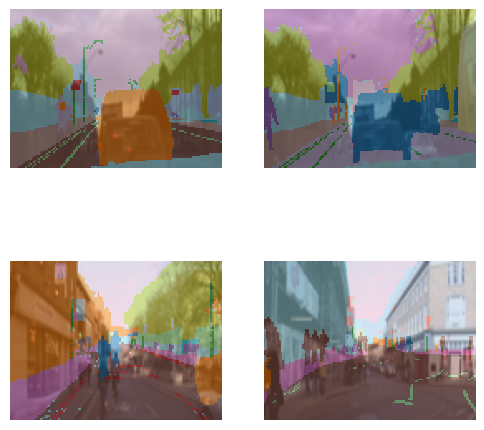

In [483]:
dls.show_batch(max_n=4)

Seems like the output is wrong, the reason comes from ImageResizer, it resized the image, but not the mask!

We can add one additional encodes() so that ImageResizr also supports PILMask:
- multiple encodes means that this transform can handle multiple types!
- not only you can reuse this transform, but you can also change behavior depending on what's preceding this transform in the pipeline!
- For example, (if we wanted) we could have ImageResizer after an Image but also after a Mask in the same pipeline!

In [484]:
class ImageResizer(Transform):
    order=1
    "Resize image to `size` using `resample`"
    def __init__(self, size, resample=BILINEAR):
        if not is_listy(size): size=(size,size)
        self.size,self.resample = (size[1],size[0]),resample

    def encodes(self, o:PILImage): return o.resize(size=self.size, resample=self.resample)
    def encodes(self, o:PILMask):  return o.resize(size=self.size, resample=NEAREST)

In [485]:
tfms = [[PILImage.create], [cv_label, PILMask.create]]
cv_dsets = Datasets(cv_items, tfms, splits=cv_split)
dls = cv_dsets.dataloaders(bs=64, after_item=[ImageResizer(128), ToTensor(), IntToFloatTensor()])

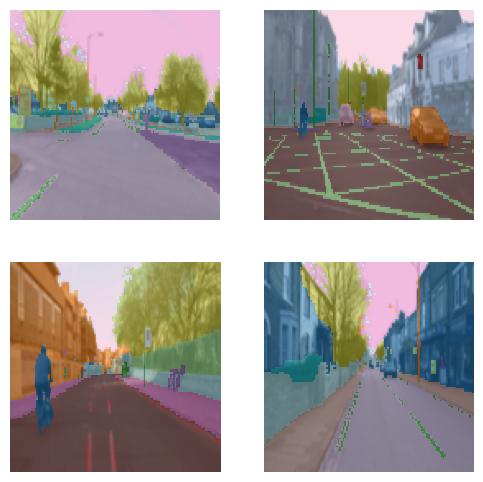

In [486]:
dls.show_batch(max_n=4)

The mask is now resized properly!

# How Do Transform Work With test_dl?

You can call `learn.get_preds` passing the above newly created dataloaders to make predictions on our new images!
What is really cool is that after you finished training your model, you can save it with `learn.export`, this is also going to save all the transforms that need to be applied to your data. In inference time you just need to load your learner with [load_learner](https://docs.fast.ai/learner.html#load_learner) and you can immediately create a dataloader with `test_dl` to use it to generate new predictions!

# [New Type of Task - Siamese Detector](https://docs.fast.ai/tutorial.siamese.html)

A Siamese model takes two images and has to determine if they are of the same class or not. For this example, we will use the Pet dataset again and prepare the data for a model that will have to predict if two images of pets are of the same breed or not.

In [35]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

In [36]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        img1,img2,same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), 
                          title=same_breed, ctx=ctx)

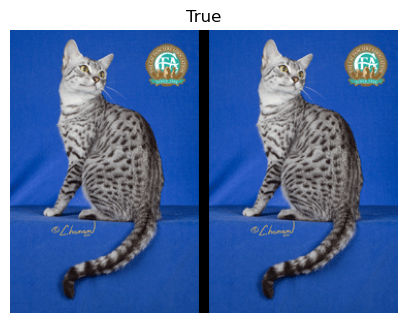

In [37]:
# Let's create a first SiameseImage and check our show method works:
img = PILImage.create(files[0])
s = SiameseImage(img, img, True)
s.show();

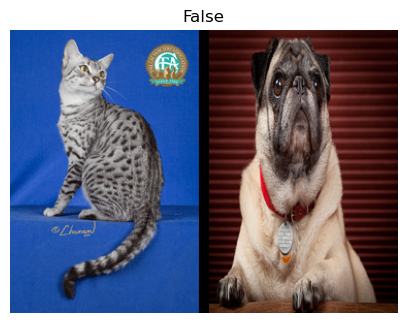

In [38]:
# We can also try with a second image that's not from the same class:
img1 = PILImage.create(files[1])
s1 = SiameseImage(img, img1, False)
s1.show();



The important thing with transforms that we saw before is that they dispatch over tuples or their subclasses. That's precisely why we chose to subclass fastuple in this instance—this way we can apply any transform that works on images to our SiameseImage and it will be applied on each image in the tuple:

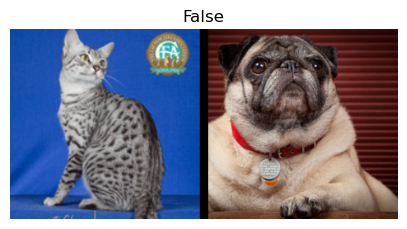

In [39]:
s2 = Resize(224)(s1)
s2.show();



Here the Resize transform is applied to each of the two images, but not the Boolean flag. Even if we have a custom type, we can thus benefit from all the data augmentation transforms inside the library.

We are now ready to build the Transform that we will use to get our data ready for a Siamese model. First, we will need a function to determine the classes of all our images:


In [40]:
def label_func(fname):
    return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]



For each image our tranform will, with a probability of 0.5, draw an image from the same class and return a SiameseImage with a true label, or draw an image from another class and return a SiameseImage with a false label. This is all done in the private _draw function. There is one difference between the training and validation sets, which is why the transform needs to be initialized with the splits: on the training set we will make that random pick each time we read an image, whereas on the validation set we make this random pick once and for all at initialization. This way, we get more varied samples during training, but always the same validation set:


In [41]:
class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(f for f in files if label_func(f) == l) 
                          for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, t)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same: 
            cls = random.choice(L(l for l in self.labels if l != cls)) 
        return random.choice(self.lbl2files[cls]),same

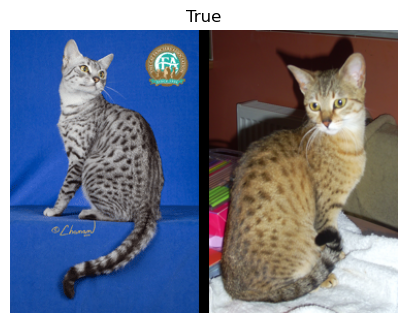

In [42]:
# We can then create our main transform
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, label_func, splits)
tfm(files[0]).show();

In the mid-level API for data collection we have two objects that can help us apply transforms on a set of items, TfmdLists and Datasets. If you remember what we have just seen, one applies a Pipeline of transforms and the other applies several Pipelines of transforms in parallel, to build tuples. Here, our main transform already builds the tuples, so we use TfmdLists:

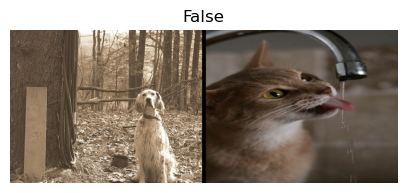

In [43]:
tls = TfmdLists(files, tfm, splits=splits)
show_at(tls.valid, 0);

In [44]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])
dls.show_batch()

TypeError: 'NoneType' object is not subscriptable

We can now train a model using this DataLoaders. It will need a bit more customization than the usual model provided by vision_learner since it has to take two images instead of one, but we will see how to create such a model and train it in the arch_details chapter